# Quantum - Quantum Optimization

In [1]:
# some standard code imports
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np

# for drawing graphs 
import networkx as nx

# qiskit imports 
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit_optimization.converters import LinearEqualityToPenalty, QuadraticProgramToQubo
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

In [2]:
# auxillary function of plot graphs 
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)

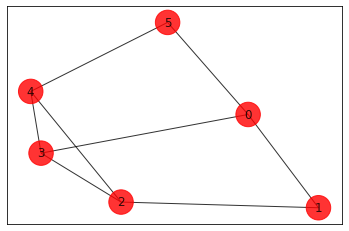

In [3]:
# create graph 
G = nx.Graph()

# add 6 nodes 
n = 6
G.add_nodes_from(range(n))

# add edges; tuple is (i,j,weight) where (i,j) is the edge 
edges = [(0, 1, 1.0), 
         (0, 3, 1.0),
         (1, 2, 1.0),
         (2, 3, 1.0),
         (2, 4, 1.0),
         (3, 4, 1.0),
         (4, 5, 1.0),
         (0, 5, 1.0)]
G.add_weighted_edges_from(edges)

# plot graph 
plot_result(G, [0]*n)

In [4]:
# name of the model
mdl = Model('MaxCut')

# add a binary variable to the model for each node in the graph 
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

# define the objective function 
objective = mdl.sum([ w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])

# add an equality constraint
b = 2
mdl.add_constraint(mdl.sum(x) == b)

# and let's maximize it!
mdl.minimize(objective)

# lets print the model 
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[6];

minimize
 3 x0 + 2 x1 + 3 x2 + 3 x3 + 3 x4 + 2 x5 [ - 2 x0*x1 - 2 x0*x3 - 2 x0*x5
 - 2 x1*x2 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 - 2 x4*x5 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 + x5 == 2;

}


In [5]:
# instantiate an empty QuadraticProgram object 
qp = QuadraticProgram()

# put the model inside it 
qp = from_docplex_mp(mdl)

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Minimize
 obj: 3 x0 + 2 x1 + 3 x2 + 3 x3 + 3 x4 + 2 x5 + [ - 4 x0*x1 - 4 x0*x3 - 4 x0*x5
      - 4 x1*x2 - 4 x2*x3 - 4 x2*x4 - 4 x3*x4 - 4 x4*x5 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 + x5 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



In [6]:
qp.objective.linear.to_dict()

{0: 3.0, 1: 2.0, 3: 3.0, 2: 3.0, 4: 3.0, 5: 2.0}

In [7]:
qp.objective.quadratic.to_dict()

{(0, 1): -2.0,
 (1, 2): -2.0,
 (0, 3): -2.0,
 (2, 3): -2.0,
 (2, 4): -2.0,
 (3, 4): -2.0,
 (0, 5): -2.0,
 (4, 5): -2.0}

In [8]:
eq_converter = LinearEqualityToPenalty()
qp_eq = eq_converter.convert(qp)
print(qp_eq.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Minimize
 obj: - 129 x0 - 130 x1 - 129 x2 - 129 x3 - 129 x4 - 130 x5 + [ 66 x0^2
      + 128 x0*x1 + 132 x0*x2 + 128 x0*x3 + 132 x0*x4 + 128 x0*x5 + 66 x1^2
      + 128 x1*x2 + 132 x1*x3 + 132 x1*x4 + 132 x1*x5 + 66 x2^2 + 128 x2*x3
      + 128 x2*x4 + 132 x2*x5 + 66 x3^2 + 128 x3*x4 + 132 x3*x5 + 66 x4^2
      + 128 x4*x5 + 66 x5^2 ]/2 + 132
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



optimal function value: 3.0
optimal value: [1. 1. 0. 0. 0. 0.]
status: SUCCESS


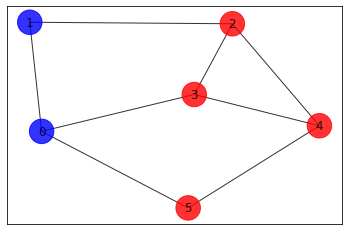

In [9]:
solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = solver.solve(qp)
print(result)
plot_result(G, result.x)

In [10]:
H, offset = qp_eq.to_ising()
print('offset -',offset)
print('h -',H)

offset - 86.5
h - -33.0 * ZIIIII
- 33.0 * IZIIII
+ 16.0 * ZZIIII
- 33.0 * IIZIII
+ 16.5 * ZIZIII
+ 16.0 * IZZIII
- 33.0 * IIIZII
+ 16.5 * ZIIZII
+ 16.0 * IZIZII
+ 16.0 * IIZZII
- 33.0 * IIIIZI
+ 16.5 * ZIIIZI
+ 16.5 * IZIIZI
+ 16.5 * IIZIZI
+ 16.0 * IIIZZI
- 33.0 * IIIIIZ
+ 16.0 * ZIIIIZ
+ 16.5 * IZIIIZ
+ 16.0 * IIZIIZ
+ 16.5 * IIIZIZ
+ 16.0 * IIIIZZ


Minimum energy for Hamiltonian: -83.5


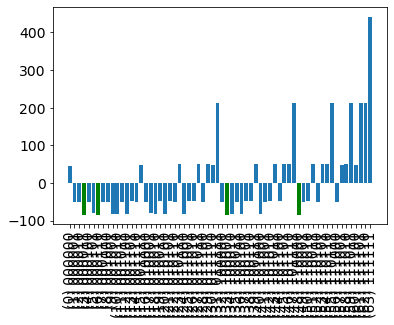

In [11]:
H_matrix = np.real(H.to_matrix())

# get the set of basis states which have the lowest energy 
opt_indicies = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]

print('Minimum energy for Hamiltonian: {0}'.format(min(H_matrix.diagonal())))
# plot the expectation value of the energy of different basis states,
# and colour those basis states which would have the losest energy 
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indicies, H_matrix.diagonal()[opt_indicies], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:06b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [12]:
seed = 10598
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(H.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(H)

# print results 
print('energy:',result.eigenvalue.real)
print('time:',result.optimizer_time)
print('max-cut objective',result.eigenvalue.real + offset)

energy: -81.41644430347945
time: 2.5724198818206787
max-cut objective 5.083555696520548


## Laboratory Activity

In [13]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = 1
print(w)

[[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0.]]


In [14]:
max_cut = Maxcut(w)
x = max_cut.sample_most_likely(result.eigenstate)
print('solution:',x)
print('solution objective:',qp.objective.evaluate(x))

solution: [0. 0. 1. 0. 1. 0.]
solution objective: 4.0
